In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

import json
import enum

from col_mnist import ColMNIST
from three_d_shapes_ds import ThreeDShapes
from models import compute_layer_blocks_out


class SupportedDatasets(enum.Enum):
    THREEDSHAPES = 0,
    COL_MNIST = 1,
    CIFAR10 = 2

In [2]:
#vgg16 = torch.load("outputs/28.09.2021(14:21:35)/model.pt") #Col MNIST model
vgg16 = torch.load("outputs/29.09.2021(16:00:55)/model.pt")
layer = vgg16.classifier[0]
layer_size = layer.out_features
ncc = vgg16.classifier[2].n_conn_comp
blocks = compute_layer_blocks_out(layer, ncc)
ds = SupportedDatasets.CIFAR10

In [3]:
if ds == SupportedDatasets.THREEDSHAPES:
    trainloader = torch.utils.data.DataLoader(
                                          ThreeDShapes(filename='data/3dshapes.h5',
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToPILImage(), 
                                                           torchvision.transforms.Resize((32, 32)),
                                                           torchvision.transforms.ToTensor(),
                                          ]), filtered = True),
                                          batch_size=32, shuffle=True)
    testloader = torch.utils.data.DataLoader(
                                          ThreeDShapes(filename='data/3dshapes.h5',
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToPILImage(), 
                                                           torchvision.transforms.Resize((32, 32)),
                                                           torchvision.transforms.ToTensor(),
                                          ]), filtered = True),
                                          batch_size=32, shuffle=True)
elif ds == SupportedDatasets.COL_MNIST:
    trainloader = torch.utils.data.DataLoader(
      ColMNIST('data/mnist', train=True, download=True,
                                 transform=torchvision.transforms.Compose([#torchvision.transforms.Resize((224, 224)),
                                   torchvision.transforms.ToTensor(),
                                 ])),
      batch_size=32, shuffle=True)

    testloader = torch.utils.data.DataLoader(
      ColMNIST('data/mnist', train=False, download=True,
                                 transform=torchvision.transforms.Compose([#torchvision.transforms.Resize((224, 224)),
                                   torchvision.transforms.ToTensor()
                                 ])),
      batch_size=32, shuffle=True)

elif ds == SupportedDatasets.CIFAR10:
    transform = transforms.Compose(
        [transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True)
    testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                            shuffle=False)
    n_classes = 10
    def target_vec_to_class(x):
        return x

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#find activations for images
class SaveOutput:
    def __init__(self):
        self.outputs = None
        
    def __call__(self, module, module_in, module_out):
        self.outputs = module_out.detach().cpu().numpy()

hook = SaveOutput()
layer.register_forward_hook(hook)
act = np.zeros((0, layer_size))

for i, data in enumerate(testloader):
    data, target = data[0], data[1]
    data = data.cuda()
    output = vgg16(data)
    act = np.concatenate((act, hook.outputs), axis=0)
    
img_shape = data[0].shape
target_shape = target[0].shape

In [5]:
target_shape

torch.Size([])

In [6]:
thr_low = np.percentile(act, 5, axis=0)
thr_high = np.percentile(act, 95, axis=0)

In [7]:
#find activations for images
class SaveOutput:
    def __init__(self):
        self.outputs = None
        
    def __call__(self, module, module_in, module_out):
        self.outputs = module_out.detach().cpu().numpy()

hook = SaveOutput()
layer.register_forward_hook(hook)

weighted_images_pos = np.zeros((layer_size, *img_shape))
weighted_images_neg = np.zeros((layer_size, *img_shape))
targets_pos = [np.zeros((0, *target_shape)) for i in range(layer_size)]
targets_neg = [np.zeros((0, *target_shape)) for i in range(layer_size)]
n_pos = np.zeros((layer_size))
n_neg = np.zeros((layer_size))

for i, data in enumerate(testloader):
    print(i)
    if i > 100:
        break
    data, target = data[0], data[1]
    data = data.cuda()
    output = vgg16(data)
    data = data.detach().cpu().numpy()

    batch_ext = np.repeat(data[:, np.newaxis, :, :], layer_size, axis=1)
    weighted_images_pos += np.average(batch_ext * np.expand_dims((hook.outputs > thr_high), axis=(2, 3, 4)), axis=0)
    weighted_images_neg += np.average(batch_ext * np.expand_dims((hook.outputs < thr_low), axis=(2, 3, 4)), axis=0)
    n_pos += (hook.outputs > thr_high).sum(axis=0)
    n_neg += (hook.outputs < thr_low).sum(axis=0)
    
    #targets of images that activated each neuron by more than the threshold
    #for j in range(layer_size):
    #    #print(target[hook.outputs[:,j] > thr_high[j]].shape)
    #    targets_pos[j] = np.concatenate([targets_pos[j], target[hook.outputs[:,j] > thr_high[j]]], axis=0)
    #    targets_neg[j] = np.concatenate([targets_neg[j], target[hook.outputs[:,j] < thr_low[j]]], axis=0)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


In [8]:
weighted_images_pos_norm = weighted_images_pos / np.expand_dims(np.max(weighted_images_pos, axis=(1, 2, 3)), axis=(1, 2, 3))
weighted_images_neg_norm = weighted_images_neg / np.expand_dims(np.max(weighted_images_neg, axis=(1, 2, 3)), axis=(1, 2, 3))
#weighted_images_pos /= n_pos[:, np.newaxis, np.newaxis, np.newaxis]
#weighted_images_neg /= n_neg[:, np.newaxis, np.newaxis, np.newaxis]

/tmp/ipykernel_15081/1901569116.py:1: RuntimeWarning: invalid value encountered in true_divide
  weighted_images_pos_norm = weighted_images_pos / np.expand_dims(np.max(weighted_images_pos, axis=(1, 2, 3)), axis=(1, 2, 3))
/tmp/ipykernel_15081/1901569116.py:2: RuntimeWarning: invalid value encountered in true_divide
  weighted_images_neg_norm = weighted_images_neg / np.expand_dims(np.max(weighted_images_neg, axis=(1, 2, 3)), axis=(1, 2, 3))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

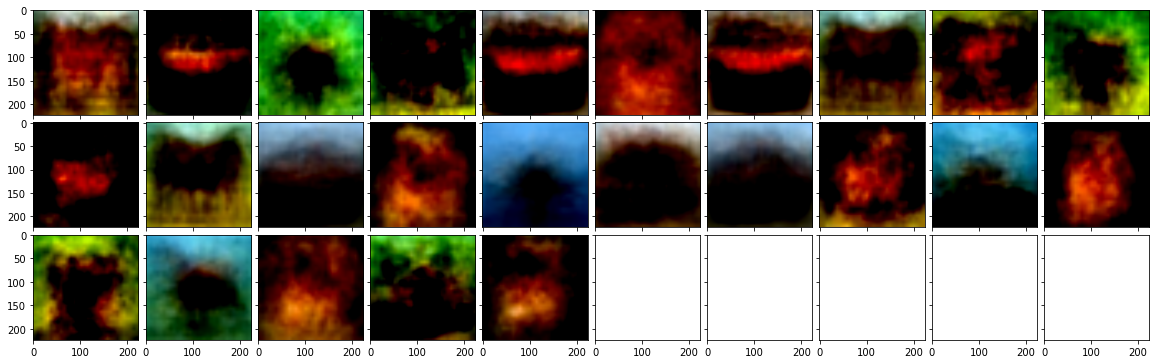

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

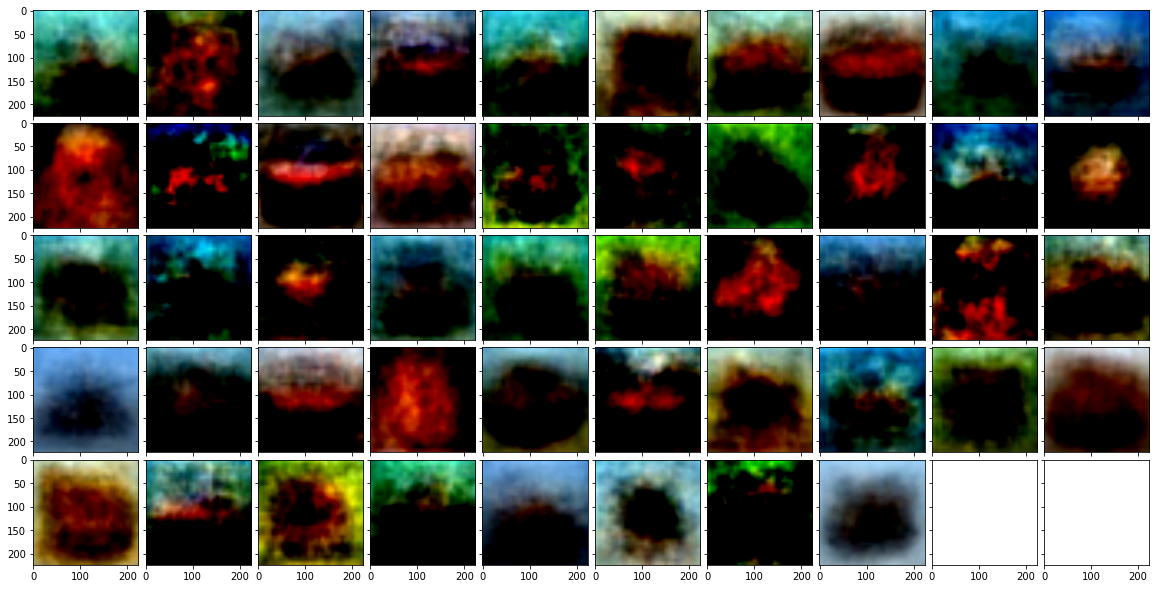

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

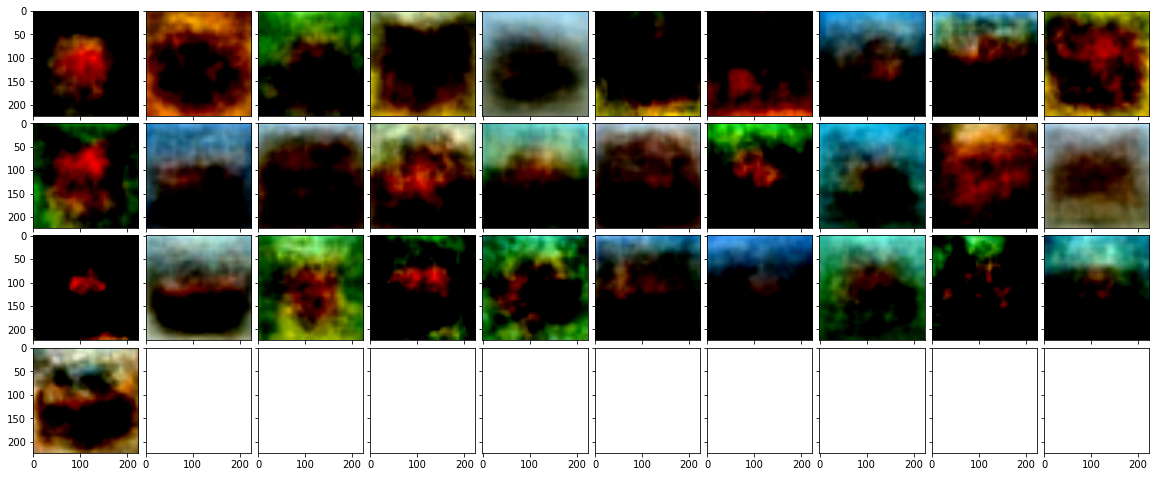

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

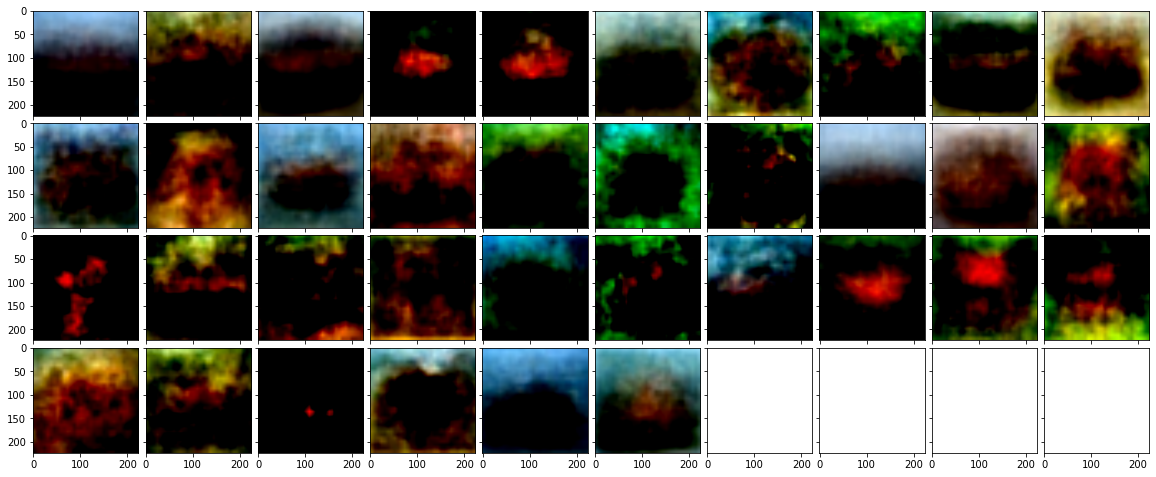

In [11]:
for c in range(ncc):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(np.ceil((blocks==c).sum()/10)), 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                    )
                     
    for ax, im in zip(grid, weighted_images_pos_norm[blocks==c]):
        ax.imshow(im.transpose(1, 2, 0))
    plt.show()
    
    #targets_pos_aggregate = np.zeros((0, *target_shape))
    #for i in range(layer_size):
    #    if blocks[i] == c:
    #        targets_pos_aggregate = np.concatenate([targets_pos_aggregate, targets_pos[i]], axis=0)
            
    #for i in range(6):
    #    fig = plt.figure(figsize=(20., 1.))
    #    plt.hist(targets_pos_aggregate[:, i])
    #    plt.show()
    #grid = ImageGrid(fig, 111,  # similar to subplot(111)
    #                 nrows_ncols=(6, 1),  # creates 2x2 grid of axes
    #                 axes_pad=0.1,  # pad between axes in inch.
    #                )
                     
    #for ax, h in zip(grid, np.swapaxes(targets_pos_aggregate, 1, 0)):
    #    ax.hist(h, bins=1024)
    #plt.gca().set_aspect('equal', adjustable='box')
    #plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

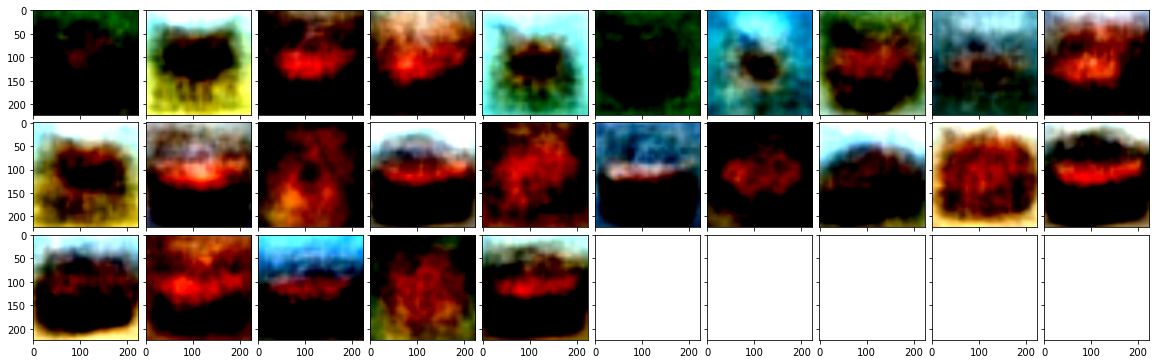

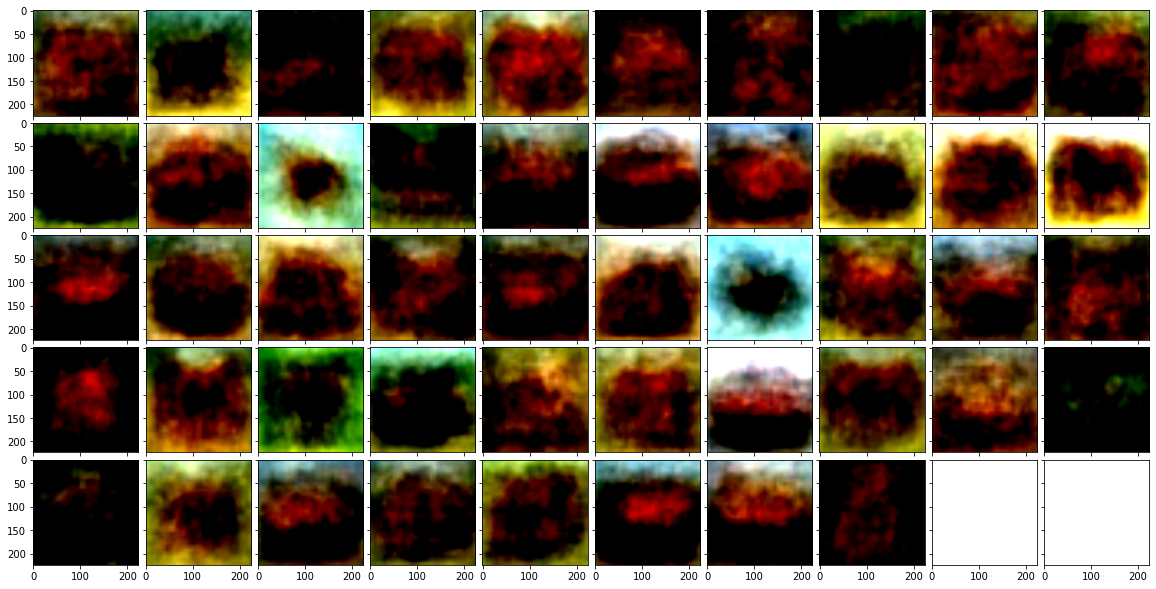

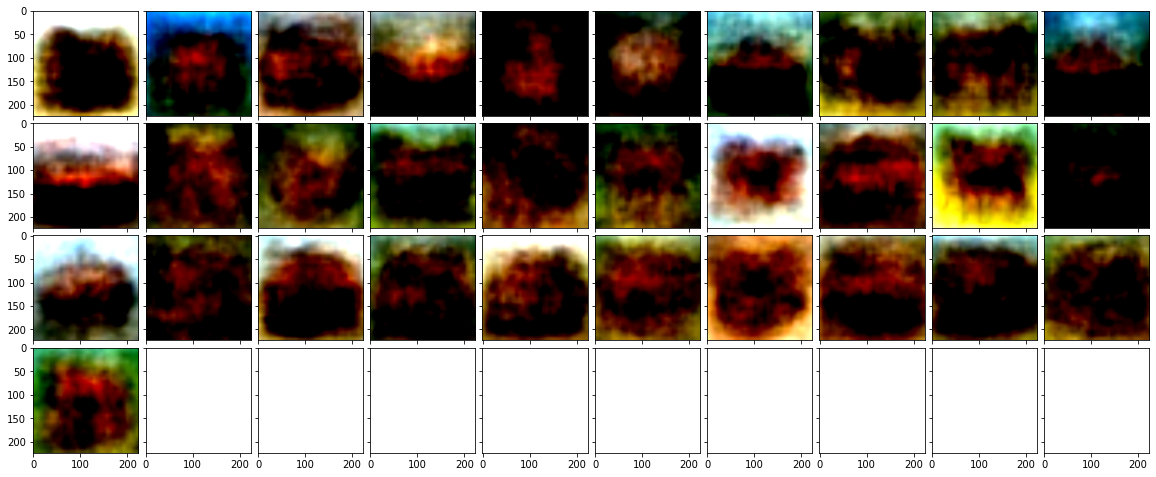

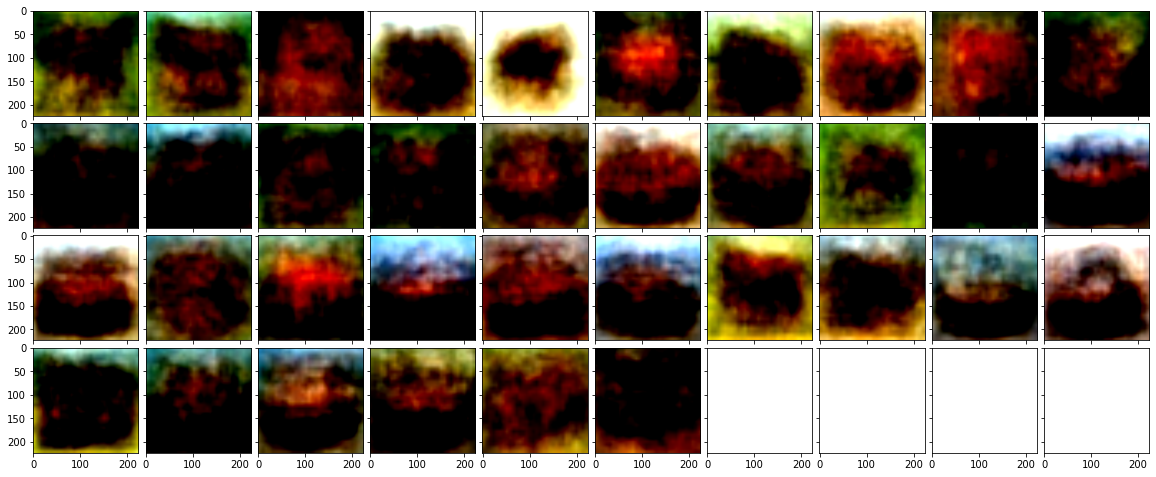

In [10]:
for c in range(ncc):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(np.ceil((blocks==c).sum()/10)), 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    
    for ax, im in zip(grid, weighted_images_neg[blocks==c]):
        ax.imshow(im.transpose(1, 2, 0))